In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
data_dir = "/content/drive/MyDrive/5334_Assignment3/mango-leaf-disease-imgclassifier-dataset"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/content/drive/MyDrive/5334_Assignment3/mango-leaf-disease-imgclassifier-dataset


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4000


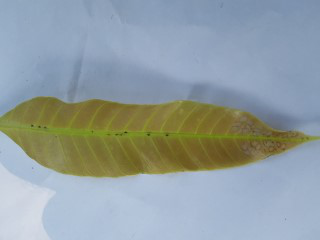

In [5]:
Anthracnose = list(data_dir.glob('Anthracnose/*'))
PIL.Image.open(str(Anthracnose[0]))

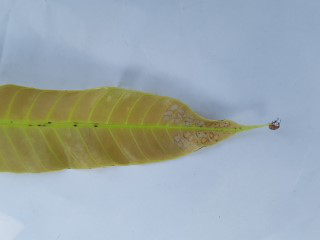

In [6]:
PIL.Image.open(str(Anthracnose[1]))

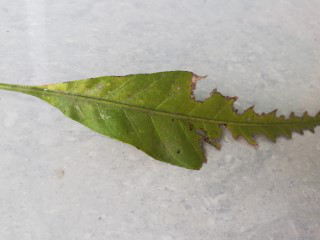

In [7]:
BacterialCanker = list(data_dir.glob('BacterialCanker/*'))
PIL.Image.open(str(BacterialCanker[0]))

In [8]:
batch_size = 32
img_height = 48
img_width = 48

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 3000 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 1000 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['Anthracnose', 'BacterialCanker', 'CuttingWeevil', 'DieBack', 'GallMidge', 'Healthy', 'PowderyMildew', 'SootyMould']


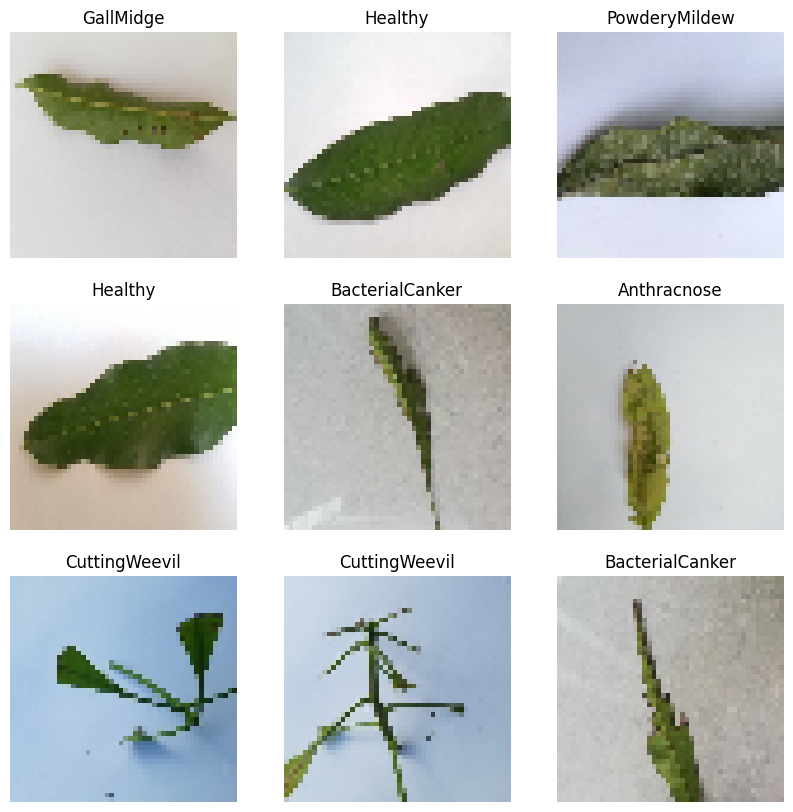

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06768797 0.8980393


In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

In [18]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
94/94 [==============================] - 132s 1s/step - loss: 1.4840 - accuracy: 0.4320 - val_loss: 0.9946 - val_accuracy: 0.6510
Epoch 2/20
94/94 [==============================] - 10s 112ms/step - loss: 0.8090 - accuracy: 0.7087 - val_loss: 0.7302 - val_accuracy: 0.7470
Epoch 3/20
94/94 [==============================] - 8s 87ms/step - loss: 0.5643 - accuracy: 0.7940 - val_loss: 0.6536 - val_accuracy: 0.7430
Epoch 4/20
94/94 [==============================] - 10s 101ms/step - loss: 0.4862 - accuracy: 0.8233 - val_loss: 0.5835 - val_accuracy: 0.7950
Epoch 5/20
94/94 [==============================] - 10s 103ms/step - loss: 0.3488 - accuracy: 0.8777 - val_loss: 0.3913 - val_accuracy: 0.8580
Epoch 6/20
94/94 [==============================] - 8s 82ms/step - loss: 0.2808 - accuracy: 0.9067 - val_loss: 0.3998 - val_accuracy: 0.8470
Epoch 7/20
94/94 [==============================] - 8s 90ms/step - loss: 0.2517 - accuracy: 0.9070 - val_loss: 0.3299 - val_accuracy: 0.8790
Epoch 8

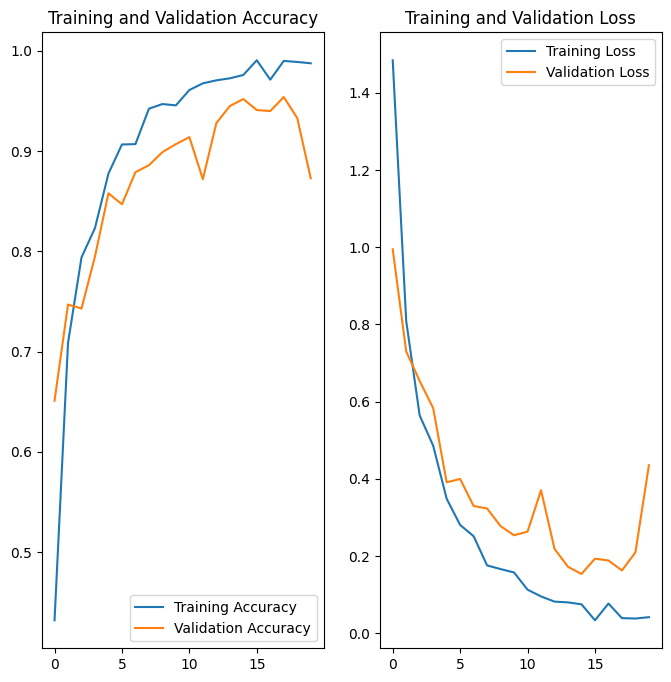

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2

In [20]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

num_classes = len(class_names)

model2 = Sequential([
    #First Convolutional layer and corresponding pooling layer
    layers.Conv2D(8, (5,5), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    #Second Convolutional layer and corresponding pooling layer
    layers.Conv2D(16, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #Third Convolutional layer and corresponding pooling layer
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #Fourth Convolutional layer and corresponding pooling layer
    layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    
    #Fully connected layer and corresponding pooling layer
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(num_classes, activation='softmax')
])

model2.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 16)        3216      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                      

In [21]:
epochs=20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


94/94 [==============================] - 15s 141ms/step - loss: 0.7335 - accuracy: 0.7517 - val_loss: 2.5743 - val_accuracy: 0.3140
Epoch 2/20
94/94 [==============================] - 13s 138ms/step - loss: 0.2736 - accuracy: 0.9190 - val_loss: 1.1992 - val_accuracy: 0.5790
Epoch 3/20
94/94 [==============================] - 13s 142ms/step - loss: 0.1782 - accuracy: 0.9463 - val_loss: 0.3553 - val_accuracy: 0.8740
Epoch 4/20
94/94 [==============================] - 13s 142ms/step - loss: 0.0974 - accuracy: 0.9770 - val_loss: 0.2273 - val_accuracy: 0.9250
Epoch 5/20
94/94 [==============================] - 13s 143ms/step - loss: 0.0546 - accuracy: 0.9883 - val_loss: 0.3255 - val_accuracy: 0.8900
Epoch 6/20
94/94 [==============================] - 12s 129ms/step - loss: 0.0263 - accuracy: 0.9983 - val_loss: 0.2843 - val_accuracy: 0.9060
Epoch 7/20
94/94 [==============================] - 13s 135ms/step - loss: 0.0101 - accuracy: 0.9997 - val_loss: 0.2461 - val_accuracy: 0.9180
Epoch 8/20

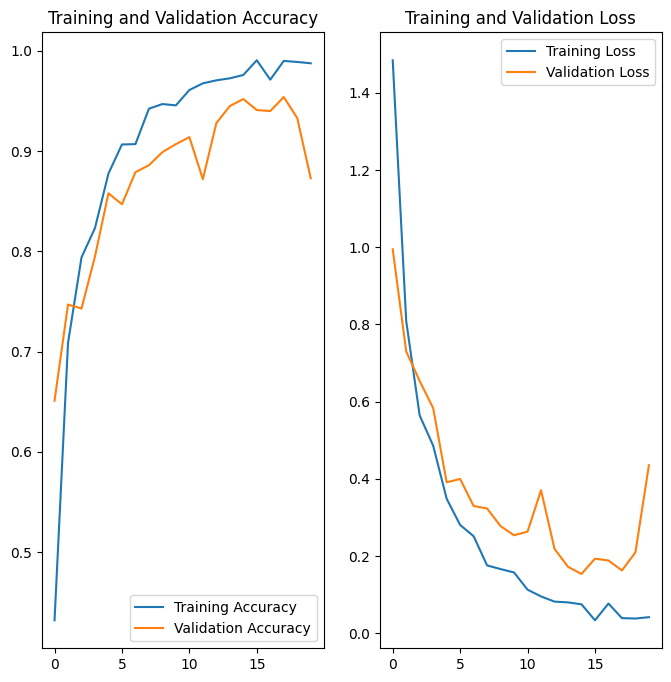

In [22]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 3

In [23]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam


data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

augmented_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(augmented_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

augmented_val_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch2, labels_batch2 = next(iter(augmented_val_ds))


num_classes = len(class_names)

model3 = Sequential([
    

    #First Convolutional layer and corresponding pooling layer
    layers.Conv2D(8, (5,5), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    #layers.Conv2D(8, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    #Second Convolutional layer and corresponding pooling layer
    layers.Conv2D(16, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #Third Convolutional layer and corresponding pooling layer
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #Fourth Convolutional layer and corresponding pooling layer
    layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    
    #Fully connected layer and corresponding pooling layer
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(num_classes, activation='softmax')
])

model3.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model3.build(input_shape=(img_height, img_width, 3, 3200))
model3.summary()

0.03529412 1.0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 8)         608       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 8)        32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 16)        3216      
                                                                 
 batch_normalization_6 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                       

In [24]:
epochs=20
history3 = model3.fit(
  augmented_train_ds,
  validation_data=augmented_val_ds,
  epochs=epochs
)

Epoch 1/20
94/94 [==============================] - 20s 187ms/step - loss: 0.7339 - accuracy: 0.7483 - val_loss: 3.9157 - val_accuracy: 0.1287
Epoch 2/20
94/94 [==============================] - 17s 178ms/step - loss: 0.2585 - accuracy: 0.9260 - val_loss: 5.6944 - val_accuracy: 0.1287
Epoch 3/20
94/94 [==============================] - 17s 183ms/step - loss: 0.1169 - accuracy: 0.9740 - val_loss: 2.9889 - val_accuracy: 0.2493
Epoch 4/20
94/94 [==============================] - 16s 167ms/step - loss: 0.0799 - accuracy: 0.9817 - val_loss: 0.7601 - val_accuracy: 0.7243
Epoch 5/20
94/94 [==============================] - 17s 184ms/step - loss: 0.0529 - accuracy: 0.9900 - val_loss: 0.3505 - val_accuracy: 0.8753
Epoch 6/20
94/94 [==============================] - 15s 157ms/step - loss: 0.0263 - accuracy: 0.9960 - val_loss: 0.1495 - val_accuracy: 0.9507
Epoch 7/20
94/94 [==============================] - 17s 183ms/step - loss: 0.0141 - accuracy: 0.9987 - val_loss: 0.0351 - val_accuracy: 0.9907

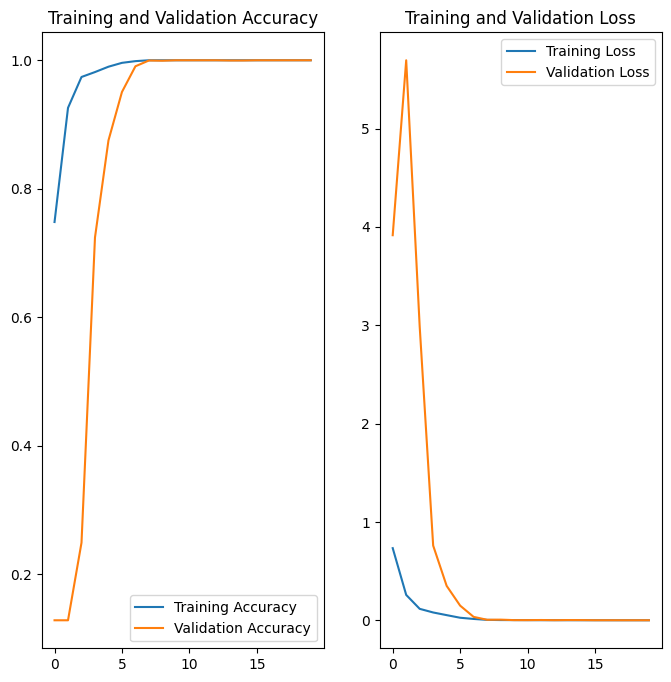

In [25]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model1_avg_accuracy = sum(history.history['accuracy'])/len(history.history['accuracy'])
print(model1_avg_accuracy)

model2_avg_accuracy = sum(history2.history['accuracy'])/len(history2.history['accuracy'])
print(model2_avg_accuracy)


model3_avg_accuracy = sum(history3.history['accuracy'])/len(history3.history['accuracy'])
print(model3_avg_accuracy)

0.9030500099062919
0.9790166705846787
0.9807333320379257


In [27]:
model1_avg_val_accuracy = sum(history.history['val_accuracy'])/len(history.history['val_accuracy'])
print(model1_avg_val_accuracy)

model2_avg_val_accuracy = sum(history2.history['val_accuracy'])/len(history2.history['val_accuracy'])
print(model2_avg_val_accuracy)


model3_avg_val_accuracy = sum(history3.history['val_accuracy'])/len(history3.history['val_accuracy'])
print(model3_avg_val_accuracy)

0.8731999963521957
0.8973499983549118
0.8523000039160251
